# Setup enviroment

In [1]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
warnings.simplefilter('ignore')

# Reading data

In [2]:
print(os.path.exists("Mobile Price Prediction Datatset.csv"))

True


In [3]:
df = pd.read_csv("Mobile Price Prediction Datatset.csv")
original_df = df.copy()

In [4]:
missing_cols = sorted(df.columns[df.isnull().any()].tolist(), key=lambda col: df[col].isnull().sum(), reverse=True)
num_rows = df.shape[0]

print(f'Number of missing values in columns:\n')
for col in missing_cols:
    print(f'{col:48} - {df[col].isnull().sum():4} ({df[col].isnull().sum() / num_rows:.1%})')

Number of missing values in columns:

Selfi_Cam                                        -  269 (32.2%)
Ratings                                          -   31 (3.7%)
RAM                                              -    7 (0.8%)
ROM                                              -    4 (0.5%)
Mobile_Size                                      -    2 (0.2%)


In [5]:
print(f'Number of unique values in columns:\n')
for col in df.columns:
    print(f'{col:50} - {df[col].nunique()}')

Number of unique values in columns:

Unnamed: 0                                         - 836
Brand me                                           - 427
Ratings                                            - 20
RAM                                                - 13
ROM                                                - 22
Mobile_Size                                        - 47
Primary_Cam                                        - 11
Selfi_Cam                                          - 23
Battery_Power                                      - 49
Price                                              - 253


# Missing values handling

In [6]:
unique_values = {col: df[col].unique() for col in df.columns}
print("\nUnique values in columns:")
for col, values in unique_values.items():
    print(f"{col}: {values}")


Unique values in columns:
Unnamed: 0: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236

***We divide the columns with missing values ​​(more than 6% and less than 6%) into two groups.***

In [7]:
random_sample_cols = [col for col in missing_cols if df[col].isnull().sum() / num_rows < 0.06]
adding_cat_cols = [col for col in missing_cols if df[col].isnull().sum() / num_rows >= 0.06]
print(random_sample_cols)
print(adding_cat_cols)

['Ratings', 'RAM', 'ROM', 'Mobile_Size']
['Selfi_Cam']


***For columns with less than 6% missing values, we use the method of replacing missing values with random values.***

In [8]:
# random sample imputation
for col in random_sample_cols:
    random_sample_train = df[col].dropna().sample(df[col].isnull().sum(), random_state=0)
    random_sample_train.index = df[df[col].isnull()].index
    df.loc[df[col].isnull(), col] = random_sample_train

In [9]:
missing_cols = sorted(df.columns[df.isnull().any()].tolist(), key=lambda col: df[col].isnull().sum(), reverse=True)
num_rows = df.shape[0]

print(f'Number of missing values in columns:\n')
for col in missing_cols:
    print(f'{col:48} - {df[col].isnull().sum():4} ({df[col].isnull().sum() / num_rows:.1%})')

Number of missing values in columns:

Selfi_Cam                                        -  269 (32.2%)


***To avoid changing the sample variance, we will replace the missing values ​​in this column with the mean.***

In [10]:
mean_value = df['Selfi_Cam'].mean()
df['Selfi_Cam'].fillna(mean_value, inplace=True)

### Result

In [11]:
missing_data = df.isnull().sum()
print(missing_data)

Unnamed: 0       0
Brand me         0
Ratings          0
RAM              0
ROM              0
Mobile_Size      0
Primary_Cam      0
Selfi_Cam        0
Battery_Power    0
Price            0
dtype: int64


# Outlier engineering
Looking at the plots from previous practice we can clearly see, that there are outliers in all of the numerical data. So have a look again.

In [12]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title(f'Histogram for {variable}')

    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel(f'Variable quantiles for {variable}')

    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title(f'Boxplot for {variable}')

    plt.show()

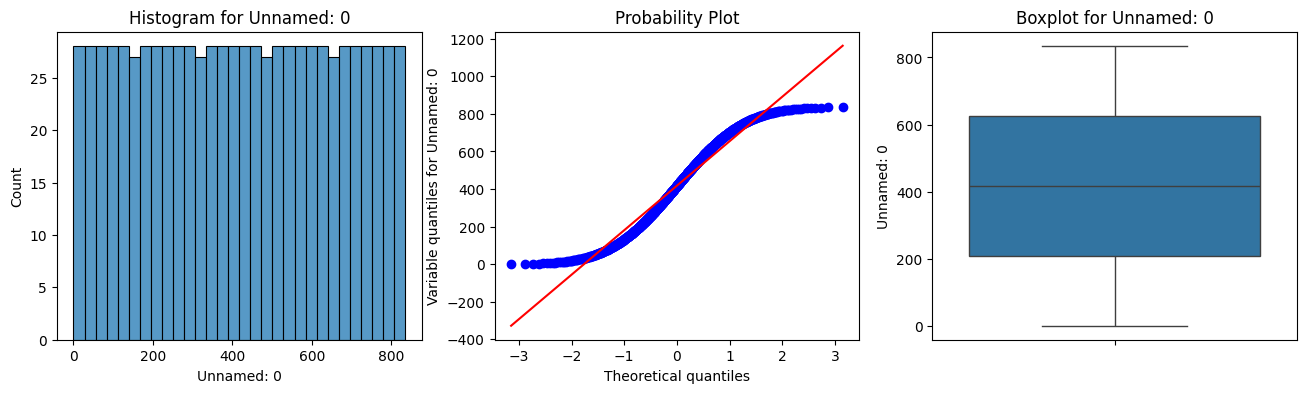

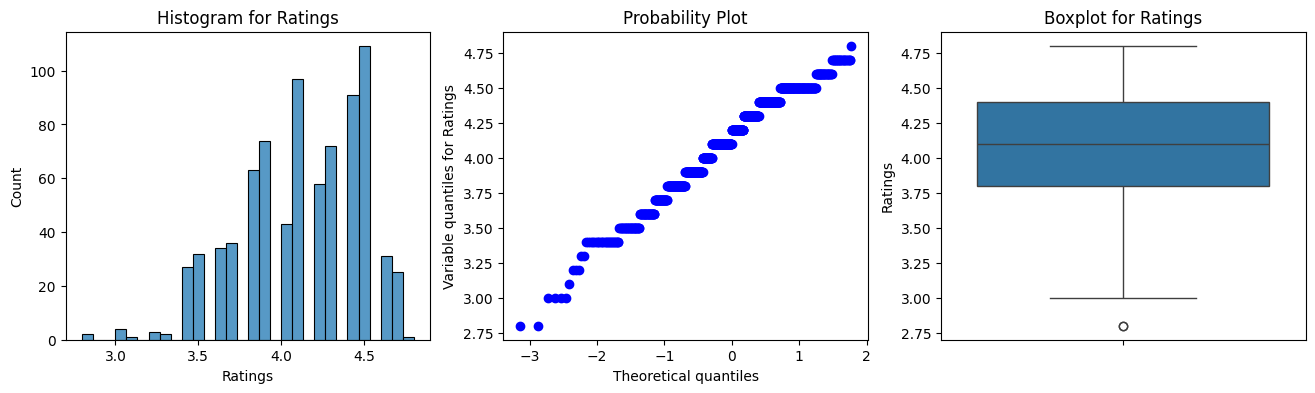

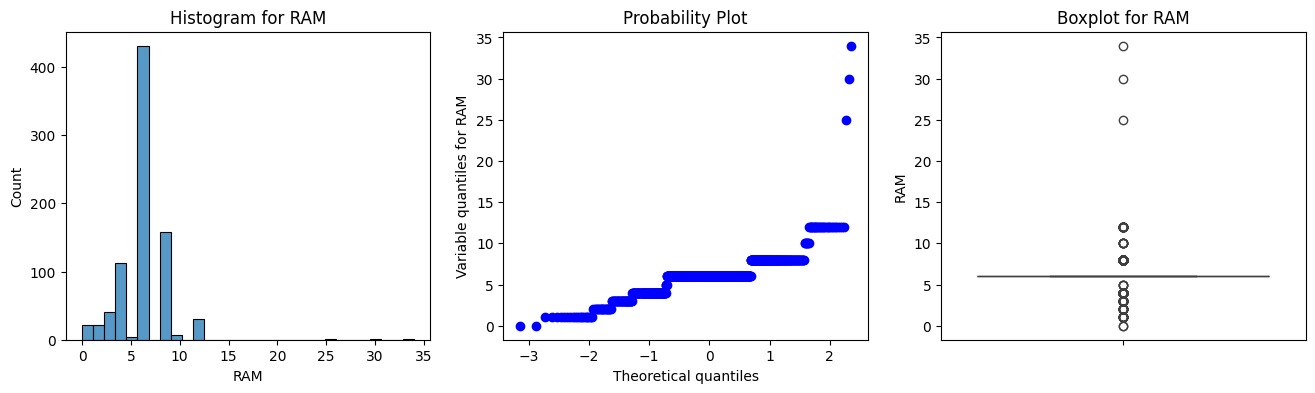

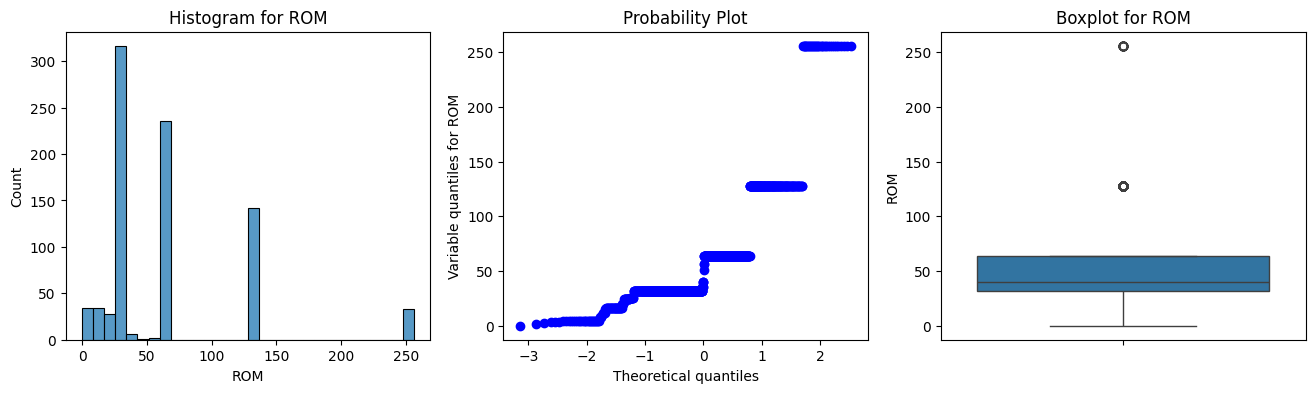

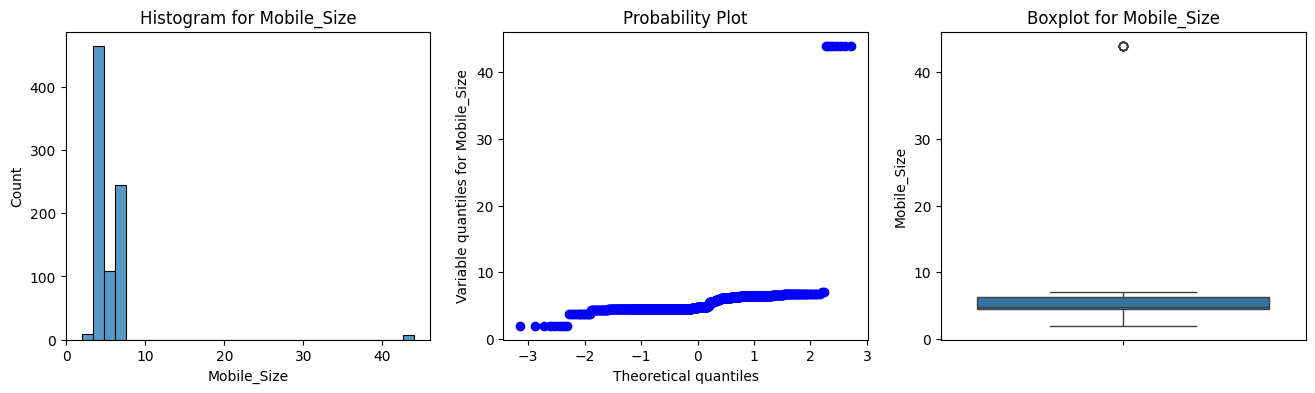

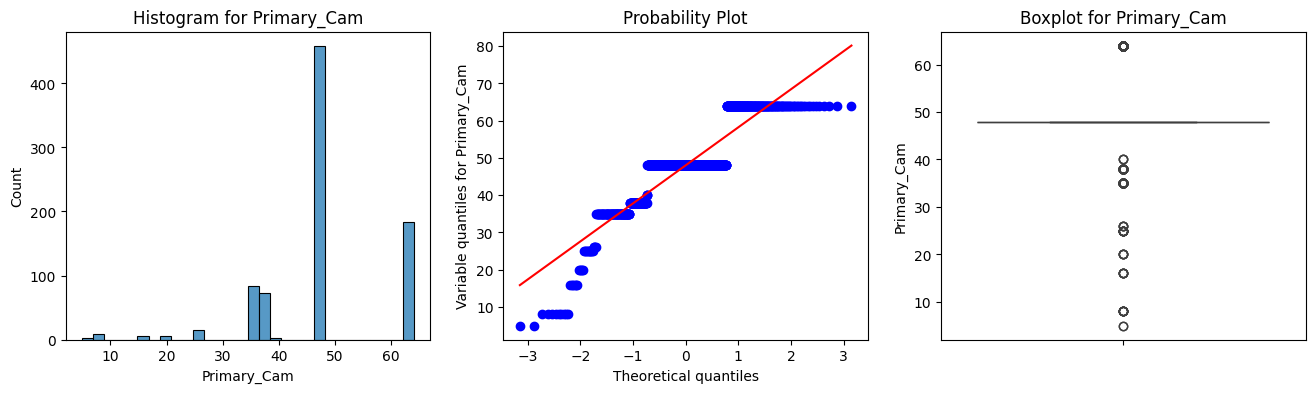

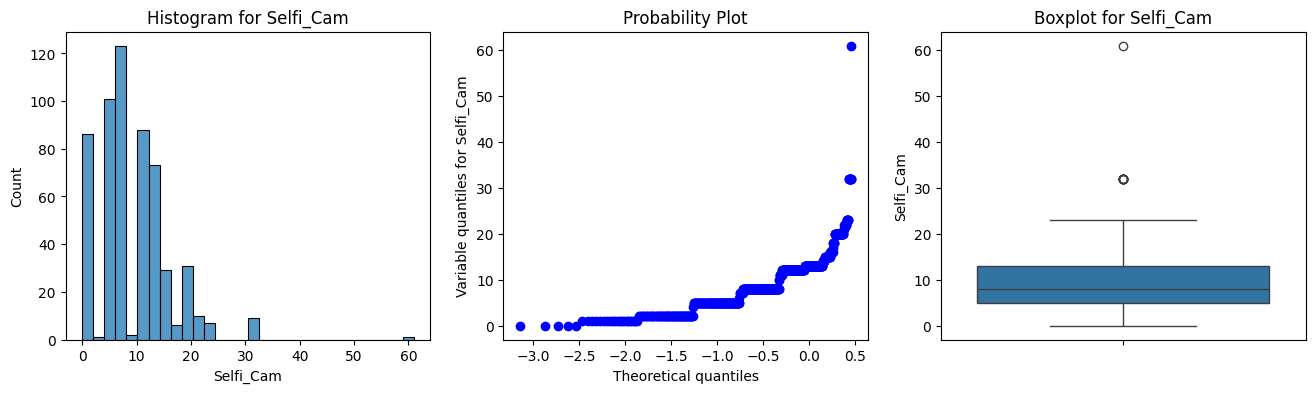

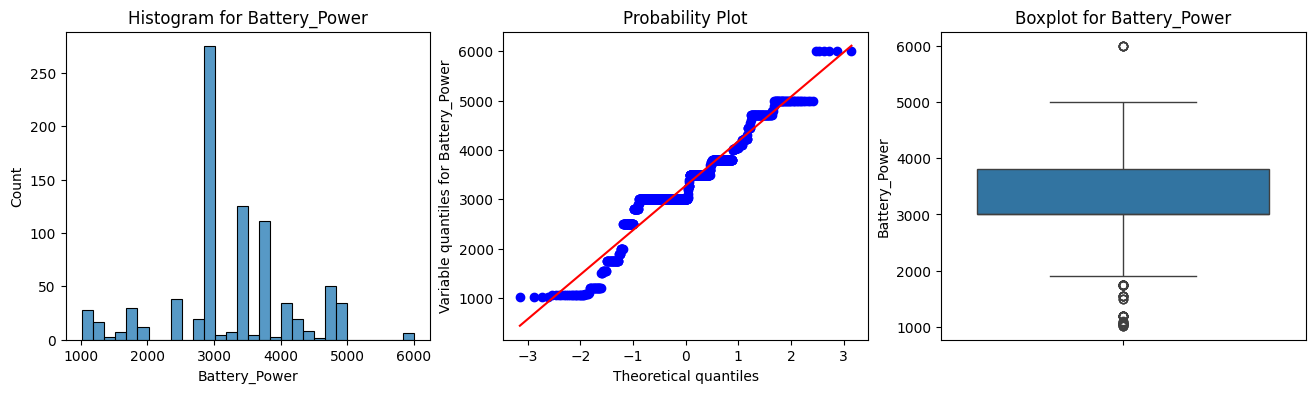

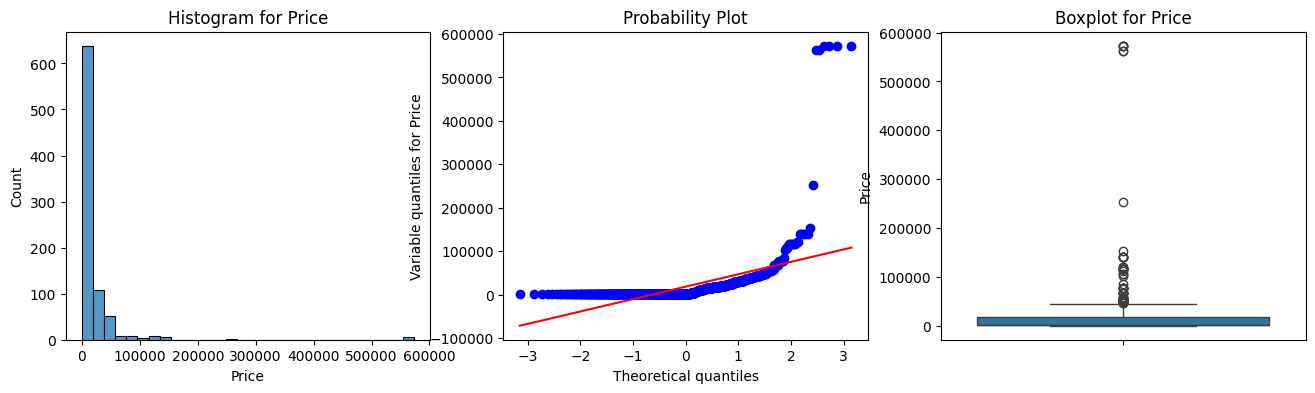

In [13]:
for col in [col for col in original_df.columns if original_df[col].dtype in ['int64', 'float64']]:
    diagnostic_plots(original_df, col)

We can clearly see, that there are outliers on some graphs, but they seem to be natural in data as these samples could be real data.

So we won't delete this outliers.

# Scaling the data
As we saw previously, our numerical data represents phisical metrics of species. So scaling with min-max would be great idea, because these numerical metrics will not shift in negative numbers.

In [14]:
cols_to_scale = [col for col in df.columns if col != 'Price']
df[cols_to_scale].describe()

,Unnamed: 0,Ratings,RAM,ROM,Mobile_Size,Primary_Cam,Selfi_Cam,Battery_Power
count,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000
mean,417.500000,4.105622,6.059809,64.228947,5.594657,47.983254,9.784832,3274.688995
std,241.476707,0.365427,2.528641,53.374889,3.894362,11.170093,5.354695,927.518852
min,0.000000,2.800000,0.000000,0.000000,2.000000,5.000000,0.000000,1020.000000
25%,208.750000,3.800000,6.000000,32.000000,4.500000,48.000000,8.000000,3000.000000
50%,417.500000,4.100000,6.000000,37.500000,4.735000,48.000000,9.784832,3000.000000
75%,626.250000,4.400000,6.000000,64.000000,6.300000,48.000000,12.000000,3800.000000
max,835.000000,4.800000,34.000000,256.000000,44.000000,64.000000,61.000000,6000.000000


In [15]:
df.drop('Brand me', axis=1, inplace=True)

In [16]:
from sklearn.preprocessing import MinMaxScaler
# set up the scaler
scaler = MinMaxScaler()
cols_to_scale = [col for col in df.columns if col != 'Brand me']
# fit the scaler to the set, it will learn the parameters, and then transform the data
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df[cols_to_scale].describe()

,Unnamed: 0,Ratings,RAM,ROM,Mobile_Size,Primary_Cam,Selfi_Cam,Battery_Power,Price
count,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000
mean,0.500000,0.652811,0.178230,0.250894,0.085587,0.728530,0.160407,0.452749,0.030988
std,0.289194,0.182714,0.074372,0.208496,0.092723,0.189324,0.087782,0.186249,0.092233
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.500000,0.176471,0.125000,0.059524,0.728814,0.131148,0.397590,0.000883
50%,0.500000,0.650000,0.176471,0.146484,0.065119,0.728814,0.160407,0.397590,0.002127
75%,0.750000,0.800000,0.176471,0.250000,0.102381,0.728814,0.196721,0.558233,0.032348
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
print(df)
# saving the preprocessed data
df.to_csv('rgr_preprocessed.csv', index=False)

     Unnamed: 0  Ratings       RAM       ROM  Mobile_Size  Primary_Cam  \
0      0.000000     0.75  0.117647  0.500000     0.095238     0.728814   
1      0.001198     0.30  0.176471  0.250000     0.059524     0.728814   
2      0.002395     0.75  0.117647  0.015625     0.059524     1.000000   
3      0.003593     0.80  0.176471  0.250000     0.104762     0.728814   
4      0.004790     0.85  0.176471  0.500000     0.099524     0.508475   
..          ...      ...       ...       ...          ...          ...   
831    0.995210     0.50  0.176471  0.125000     0.060476     0.728814   
832    0.996407     0.65  0.235294  0.250000     0.060476     1.000000   
833    0.997605     0.80  0.088235  0.125000     0.100000     0.728814   
834    0.998802     0.45  0.294118  0.125000     0.059524     1.000000   
835    1.000000     0.35  0.176471  0.125000     0.059524     1.000000   

     Selfi_Cam  Battery_Power     Price  
0     0.213115       0.598394  0.042828  
1     0.196721       0.5983